# Sales Testing - modified data from sales scenario

This following notebook uses synthetic data generated from a real world data set. It has been treated to remove the real world meaning behind the data, but remains useful for demonstration of techniques

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from statsmodels.stats.power import TTestIndPower


from google.cloud import bigquery
from google.oauth2 import service_account
from google.api_core.exceptions import NotFound

import datetime as dt

#Needed for bigquery writing
## Big Query libraries
from google.oauth2.service_account import Credentials

# The data comes from a sales experiment where a treatment was introduced into the retail sales stores.

Assumptions include:
1) No in-store promotions
2) independent data per week

# FINDINGS

We observed an average increase of approximately $1,065 in weekly revenue following the treatment period. Applying a 45% gross margin, this translates to $479 in incremental weekly gross profit. After accounting for the $105 weekly advertising cost, the net impact is an estimated $374 in additional profit per week, or approximately $19,500 in incremental annual profit.

To evaluate whether this change was statistically meaningful, we conducted a t-test comparing the pre-treatment (Period A) and post-treatment (Period B) sales performance. The results were statistically significant (p < 0.05), leading us to reject the null hypothesis. This provides evidence that the treatment had a significant positive effect on sales.

In [15]:
sample_data = pd.read_csv(r"sample_data_synthetic.csv", parse_dates=['week_adjusted'])

In [16]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   week_adjusted  55 non-null     datetime64[ns]
 1   shifted_data   55 non-null     float64       
 2   Period         55 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ KB


# Evaluate the Null Hypothesis:

The null hypothesis states that Period A and Period B do not have a difference in their mean sales.

The alternative hypothesis is that there is a difference in mean sales.

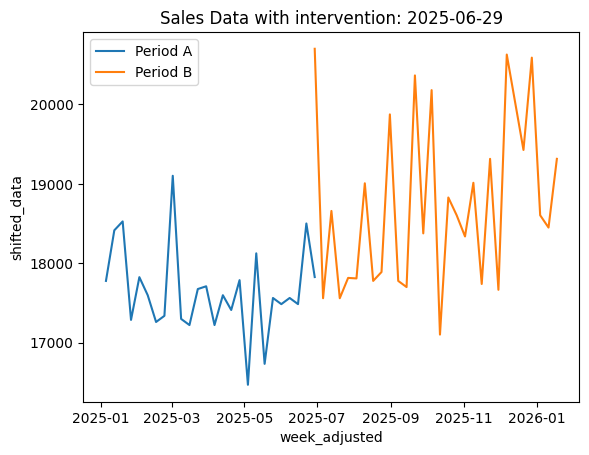

In [30]:
intervention_begins = sample_data[sample_data['Period'] == 'B']['week_adjusted'].min().strftime("%Y-%m-%d")

sns.lineplot(data = sample_data[sample_data['Period'] == 'A'], x='week_adjusted', y='shifted_data', label='Period A')
sns.lineplot(data = sample_data[sample_data['Period'] == 'B'], x='week_adjusted', y='shifted_data', label='Period B')
plt.legend()
plt.title(f'Sales Data with intervention: {intervention_begins}');

# Run Statistical Test to determine if the data is significantly different

In [31]:
df_A= sample_data[sample_data['Period'] == "A"]
df_B= sample_data[sample_data['Period'] == "B"]

In [33]:
# Run Levene's Test
stat, p_levene = stats.levene(df_B['shifted_data'], df_A['shifted_data'])

print(f"Levene’s Test p-value: {p_levene:.4f}")

if p_levene < 0.05:
    print("Variances are NOT equal. Use Welch's T-test (equal_var=False).")
else:
    print("Variances are equal. Use standard T-test.")

Levene’s Test p-value: 0.0015
Variances are NOT equal. Use Welch's T-test (equal_var=False).


# T-test results p-value less than .05

A p-value of less than alpha, .05, indicates a statistically significant different and we can reject the null hypothesis. Therefore, we state that these results are unlikely to have happened by chance. From this test, we determine that the retail sales intervention produced meaningful results. 

In [34]:
t_stat, p_val = stats.ttest_ind(df_B['shifted_data'], df_A['shifted_data'], equal_var=False)

print(f"Welch's T-test t-stat:: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

Welch's T-test t-stat:: 4.7340
P-value: 0.0000


In [50]:
def sales_histogram_comparison(df1,df2, variable, label1, label2):
    sns.histplot(df1[variable], label=label1,alpha=1)
    sns.histplot(df2[variable], label=label2,alpha=.6)
    plt.title("Sales Data Distributions")
    plt.legend()

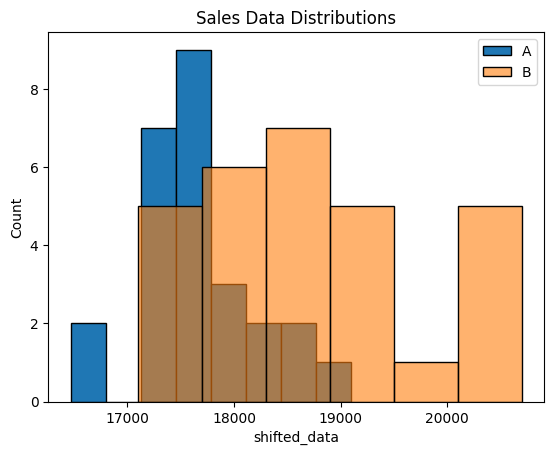

In [51]:
sales_histogram_comparison(df_A, df_B, 'shifted_data', 'A', 'B')

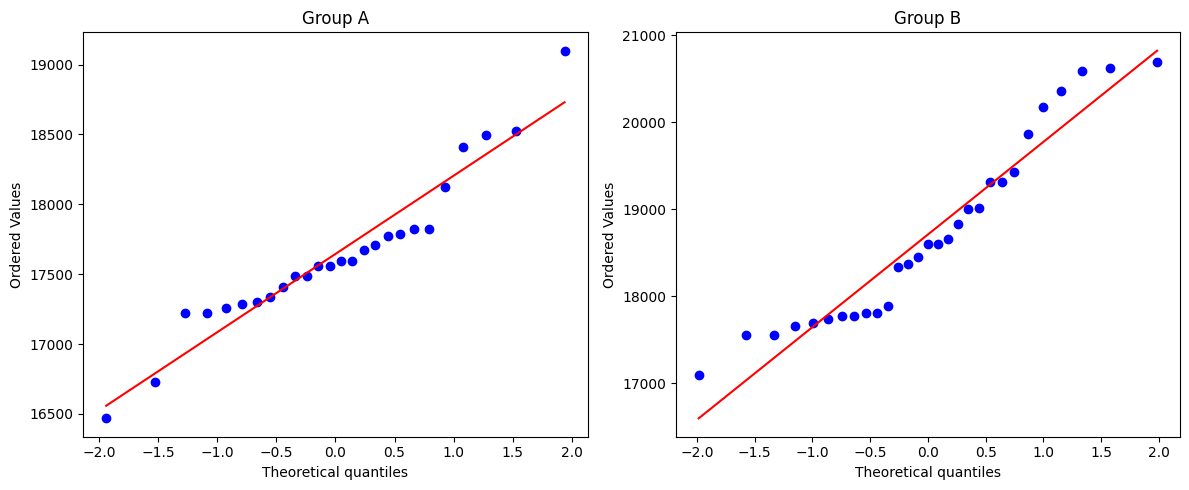

In [52]:
# Assuming 'group1' is Adelie and 'group2' is Gentoo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Q-Q plot for Group 1 (Adelie)
stats.probplot(df_A['shifted_data'], dist="norm", plot=ax1)
ax1.set_title("Group A")

# Q-Q plot for Group 2 (Gentoo)
stats.probplot(df_B['shifted_data'], dist="norm", plot=ax2)
ax2.set_title("Group B")

plt.tight_layout()

In [55]:
def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Calculate pooled standard deviation
    pooled_sd = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Calculate d
    return (np.mean(group1) - np.mean(group2)) / pooled_sd

In [58]:
effect_size = cohen_d(df_A['shifted_data'], df_B['shifted_data'])
effect_size

np.float64(-1.2388217338501422)

In [60]:
analysis = TTestIndPower()

# Using your specific numbers
calc_power = analysis.solve_power(
    effect_size=1.2359, 
    nobs1=25,           # Use the first group size
    ratio=1.16,         # 29 / 25
    alpha=0.05, 
    power=None
)

print(f"Adjusted Statistical Power: {calc_power:.4f}")

Adjusted Statistical Power: 0.9935


In [61]:
(df_A['shifted_data'].mean() - df_B['shifted_data'].mean()) * -1

np.float64(1065.9810875331568)

# Findings


We observed an average increase of approximately $1,065 in weekly revenue following the treatment period. Applying a 45% gross margin, this translates to $479 in incremental weekly gross profit. After accounting for the $105 weekly advertising cost, the net impact is an estimated $374 in additional profit per week, or approximately $19,500 in incremental annual profit.

To evaluate whether this change was statistically meaningful, we conducted a t-test comparing the pre-treatment (Period A) and post-treatment (Period B) sales performance. The results were statistically significant (p < 0.05), leading us to reject the null hypothesis. This provides evidence that the treatment had a significant positive effect on sales.